In [1]:
print('Pytorch的五个层次结构,从低到高f分别为:硬件层, 内核层(c++实现), 低阶API,中阶API, 高阶API')

Pytorch的五个层次结构,从低到高f分别为:硬件层, 内核层(c++实现), 低阶API,中阶API, 高阶API


In [2]:
print('下面的范例用的是低阶API实现线性回归模型和DNN二分类模型')
print('低阶API包括:张量操作, 计算图和自动微分')

下面的范例用的是低阶API实现线性回归模型和DNN二分类模型
低阶API包括:张量操作, 计算图和自动微分


### 1. 线性回归模型

In [26]:
import datetime
print('现在的时间为:', datetime.datetime.now())

现在的时间为: 2022-04-27 16:26:39.404089


In [27]:
#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#### 1.1 准备数据

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

In [8]:
torch.normal(0.0, 2.0, size = [2, 1])

tensor([[-0.8756],
        [-0.0762]])

In [9]:
torch.tensor([[2.0], [-3.0]])

tensor([[ 2.],
        [-3.]])

In [6]:
n = 400 # 样本数量

# 生成测试数据集
x = 20 * torch.rand([n, 2]) - 5.0  # (400, 2)
w0 = torch.tensor([[2.0], [-3.0]]) # (2, 1)
b0 = torch.tensor([[10.0]])
y = x @ w0 + b0 + torch.normal(0.0, 2.0, size = [n, 1])
print('x的行列数分别为:', x.size())

x的行列数分别为: torch.Size([400, 2])


Text(0, 0.5, 'y')

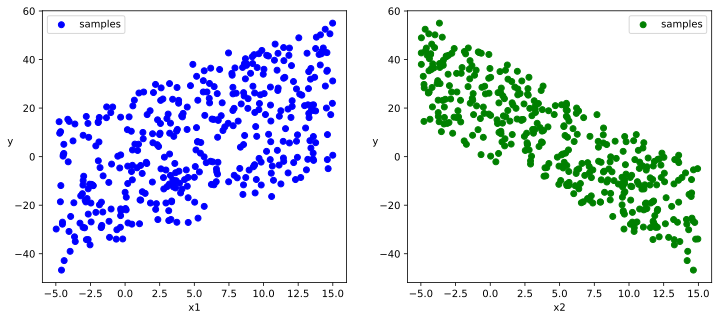

In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (12, 5))
ax1 = plt.subplot(121)
ax1.scatter(x[:, 0].numpy(), y[:, 0].numpy(), c = 'b', label = 'samples')
ax1.legend()
plt.xlabel('x1')
plt.ylabel('y', rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(x[:, 1].numpy(), y[:, 0].numpy(), c = 'g', label = 'samples')
ax2.legend()
plt.xlabel('x2')
plt.ylabel('y', rotation = 0)

In [ ]:
#index_select(dim,index)
# dim：表示从第几维挑选数据，类型为int值
# index: 表示从第一个参数维度中的哪个位置挑选数据

In [36]:
# 测试

t = torch.arange(6).reshape(2, 3)
print('t----->', t)

index = torch.tensor([1, 2]) # 要选取数据的位置
print("index--->", index)

data1 = t.index_select(1, index) # 第一个参数:从第1维挑选， 第二个参数:从该维中挑选的位置
print("data1--->", data1)


t-----> tensor([[0, 1, 2],
        [3, 4, 5]])
index---> tensor([1, 2])
data1---> tensor([[1, 2],
        [4, 5]])


In [28]:
# 构建数据管道迭代器
print('构建数据管道迭代器')
def data_iter(features, labels, batch_size=8):
    num_examples = len(features) # 400
    indices = list(range(num_examples)) # 0到399的一个list
    np.random.shuffle(indices)  #打乱顺序
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield  features.index_select(0, indexs), labels.index_select(0, indexs) 

batch_size = 8
(features, labels) = next(data_iter(x, y, batch_size = batch_size))
print('features:',features)
print('labels:', labels)

构建数据管道迭代器
features: tensor([[ 5.2364,  6.0479],
        [ 6.1824, -4.2260],
        [ 4.5601, 14.7395],
        [-4.5211, 10.2403],
        [12.4511,  8.1459],
        [ 2.4908,  1.5850],
        [-1.5861,  4.0051],
        [ 6.3319,  8.6373]])
labels: tensor([[  6.2239],
        [ 36.4491],
        [-27.1090],
        [-26.9803],
        [  8.9859],
        [  9.1147],
        [ -7.9112],
        [ -2.1453]])


#### 1.2 定义模型

In [40]:
print('定义模型')
class LinearRegression:

    def __init__(self):
        self.w = torch.rand_like(w0, requires_grad = True) # (2,1 )
        self.b = torch.zeros_like(b0, requires_grad = True)

    # 正向传播
    def forward(self, x):
        return x @ self.w + self.b

    # 损失函数
    def loss_fnc(self, y_pred, y_true):
        return torch.mean((y_pred - y_true) ** 2 / 2)
model = LinearRegression()

定义模型


In [41]:
model

#### 1.3 训练模型

In [47]:
def train_step(model, features, labels):
    predictions = model.forward(features)
    #print(predictions)
    loss = model.loss_fnc(predictions, labels)

    # 反向求梯度
    loss.backward()

    # 使用torch.no_grad()避免梯度记录，也可以通过操作model.w.data 实现避免梯度记录
    with torch.no_grad():
        # 梯度下降法更新参数
        model.w -= 0.001 * model.w.grad
        model.b -= 0.001 * model.b.grad

        # 梯度清零
        model.w.grad.zero_()
        model.b.grad.zero_()
    return loss


In [48]:
# 测试效果
batch_size = 10
(features, labels) = next(data_iter(x, y, batch_size))
train_step(model, features, labels)

tensor(229.7874, grad_fn=<MeanBackward0>)

In [57]:
def train_model(model, epochs):
    for epoch in range(1, epochs + 1):
        for features, labels in data_iter(x, y, 10):
            loss = train_step(model, features, labels)

        if epoch % 200 == 0:
            printbar()
            print("epoch =",epoch,"loss = ",loss.item())
            print("model.w =",model.w.data)
            print("model.b =",model.b.data)
train_model(model, epochs = 2000)


================================================================================2022-04-26 22:05:41
epoch = 200 loss =  2.0335917472839355
model.w = tensor([[ 2.0001],
        [-2.9929]])
model.b = tensor([[9.9929]])

================================================================================2022-04-26 22:05:43
epoch = 400 loss =  1.276150107383728
model.w = tensor([[ 2.0013],
        [-2.9877]])
model.b = tensor([[9.9940]])

================================================================================2022-04-26 22:05:44
epoch = 600 loss =  4.801802635192871
model.w = tensor([[ 2.0001],
        [-3.0021]])
model.b = tensor([[9.9930]])

================================================================================2022-04-26 22:05:45
epoch = 800 loss =  1.5753930807113647
model.w = tensor([[ 1.9971],
        [-2.9847]])
model.b = tensor([[9.9934]])

================================================================================2022-04-26 22:05:46
epoch = 1000 loss =  4.099228

Text(0, 0.5, 'y')

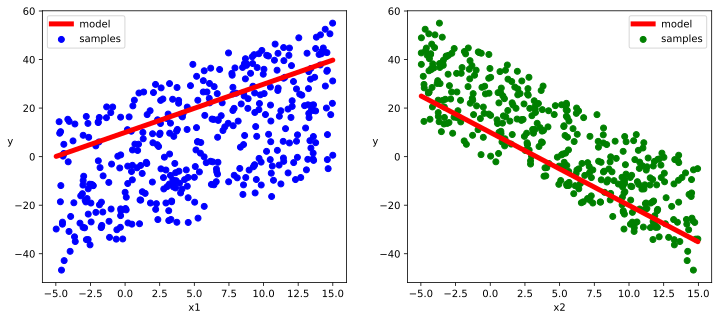

In [60]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(x[:,0].numpy(),y[:,0].numpy(), c = "b",label = "samples")
ax1.plot(x[:,0].numpy(),(model.w[0].data*x[:,0]+model.b[0].data).numpy(),"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(x[:,1].numpy(),y[:,0].numpy(), c = "g",label = "samples")
ax2.plot(x[:,1].numpy(),(model.w[1].data*x[:,1]+model.b[0].data).numpy(),"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

### 2. DNN二分类模型

#### 2.1 准备数据

In [28]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [29]:
# 正，负样本数量
print('正，负样本数量')
n_positive, n_negative = 2000, 2000

正，负样本数量


In [30]:
torch.normal(0.0, 1.0, size = [2, 1])

tensor([[-0.3975],
        [ 0.1028]])

In [31]:
torch.rand([2, 1])

tensor([[0.5934],
        [0.5827]])

In [33]:
theta_n = 2 * np.pi * torch.rand([2, 1])
theta_n

tensor([[0.2504],
        [1.7632]])

In [34]:
xn = torch.cos(theta_n)
xn

tensor([[ 0.9688],
        [-0.1912]])

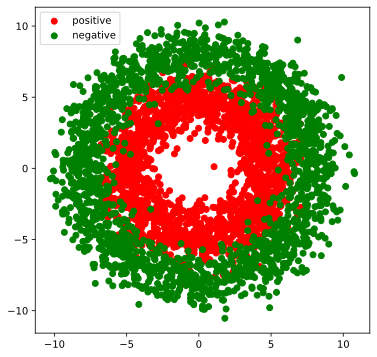

In [35]:
# 生成正样本，小圆环分布
r_p = 5.0 + torch.normal(0.0, 1.0, size = [n_positive, 1])
theta_p = 2 * np.pi * torch.rand([n_positive, 1])
xp = torch.cat([r_p * torch.cos(theta_p), r_p * torch.sin(theta_p)], axis = 1)
yp = torch.ones_like(r_p)


# 生成负样本，大圆环分布
r_n = 8.0 + torch.normal(0.0, 1.0, size = [n_negative, 1])
theta_n = 2 * np.pi * torch.rand([n_negative, 1])
xn = torch.cat([r_n * torch.cos(theta_n), r_n * torch.sin(theta_n)], axis = 1)
yn = torch.zeros_like(r_n)

# 汇总样本
x = torch.cat([xp, xn], axis = 0)
y = torch.cat([yp, yn], axis = 0)

# 可视化
plt.figure(figsize = (6, 6))
plt.scatter(xp[:, 0].numpy(), xp[:, 1].numpy(), c= 'r')
plt.scatter(xn[:, 0].numpy(), xn[:, 1].numpy(), c = 'g')
plt.legend(['positive', 'negative'])

In [7]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield  features.index_select(0, indexs), labels.index_select(0, indexs)
        
# 测试数据管道效果   
batch_size = 8
(features,labels) = next(data_iter(x,y,batch_size))
print('features:', features)
print('labels:', labels)

features: tensor([[-3.9024, -7.4939],
        [-6.9884, -0.7795],
        [ 5.4500,  2.1820],
        [-3.6551,  3.8413],
        [-4.7464, -0.7830],
        [-7.3732, -4.8963],
        [-3.5218,  7.9160],
        [-4.4930,  4.3187]])
labels: tensor([[0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.]])


#### 2.2 定义模型

In [11]:
print('此范例利用nn.Moudle来组织模型变量')
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.w1 = nn.Parameter(torch.randn(2, 4))
        self.b1 = nn.Parameter(torch.randn(1, 4))

        self.w2 = nn.Parameter(torch.randn(4, 8))
        self.b2 = nn.Parameter(torch.randn(1, 8))

        self.w3 = nn.Parameter(torch.randn(8, 1))
        self.b3 = nn.Parameter(torch.randn(1, 1))

# 正向传播
    def forward(self, x):
        x = torch.relu(x @ self.w1 + self.b1)
        x = torch.relu(x @ self.w2 + self.b2)
        y = torch.sigmoid(x @ self.w3 + self.b3)
        return y


    # 损失函数（二元交叉熵）
    def loss_func(self, y_pred, y_true):
        eps = 1e-7 # 将预测值限制在1e-7以上
        # torch.clamp(input, min, max, out=None) 限幅。将input的值限制在[min, max]之间，并返回结果。
        y_pred = torch.clamp(y_pred, eps, 1.0 - eps)
        bce = - y_true * torch.log(y_pred) - (1 - y_true) * torch.log(1 - y_pred)
        return torch.mean(bce)

    # 评估指标(准确率)
    def metric_func(self, y_pred, y_true):
        y_pred = torch.where(y_pred > 0.5, torch.ones_like(y_pred, dtype = torch.float32), torch.zeros_like(y_pred, dtype = torch.float32))
        acc = torch.mean(1 - torch.abs(y_true - y_pred))
        return acc
model = DNNModel()

此范例利用nn.Moudle来组织模型变量


In [12]:
# 测试模型结构
batch_size = 10
(features, labels) = next(data_iter(x, y, batch_size))
predictions = model(features)
loss = model.loss_func(labels, predictions)
metric = model.metric_func(labels, predictions)
print('init loss：', loss.item())
print('init metric:', metric.item())


init loss： 3.3718247413635254
init metric: 0.788625180721283


In [13]:
len(list(model.parameters()))

6

In [14]:
model.parameters()

<generator object Module.parameters at 0x000002370D4549E0>

#### 2.3 训练模型

In [16]:
def train_step(model, features, labels):
    # 正向传播求损失
    predictions = model.forward(features)
    loss = model.loss_func(predictions, labels)
    metric = model.metric_func(predictions, labels)

    # 反向传播求梯度
    loss.backward()
    # 梯度下降法更新参数
    for param in model.parameters():
        # 注意是对param.data进行重新赋值，避免在此操作引起梯度记录
        param.data = (param.data - 0.01 * param.grad.data)

    # 梯度清零
    model.zero_grad()
    return loss.item(), metric.item()

In [22]:
def train_model(model, epochs):
    for epoch in range(1, epochs + 1):
        loss_list, metric_list = [], []
        for features, labels in data_iter(x, y, 20):
            lossi, metrici = train_step(model, features, labels)
            loss_list.append(lossi)
            metric_list.append(metrici)
        loss = np.mean(loss_list)
        metric = np.mean(metric_list)

        if epoch % 100 == 0:
            printbar()
            print('epoch= ', epoch, 'loss = ', loss, 'metric = ', metric)
train_model(model, epochs = 1000)


================================================================================2022-04-27 09:44:20
epoch=  100 loss =  0.15464307951042428 metric =  0.9412499928474426

================================================================================2022-04-27 09:44:32
epoch=  200 loss =  0.15381758511066437 metric =  0.9394999924302101

================================================================================2022-04-27 09:44:44
epoch=  300 loss =  0.15394373272079975 metric =  0.9357499927282333

================================================================================2022-04-27 09:44:56
epoch=  400 loss =  0.15533820101059972 metric =  0.9402499923110008

================================================================================2022-04-27 09:45:07
epoch=  500 loss =  0.15228225665166975 metric =  0.9427499923110009

================================================================================2022-04-27 09:45:20
epoch=  600 loss =  0.15361603619065137 metric = 

Text(0.5, 1.0, 'y_pred')

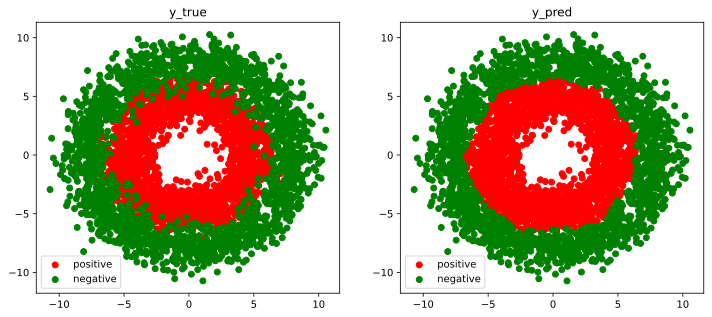

In [25]:
# 结果可视化
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
ax1.scatter(xp[:, 0], xp[:, 1], c= 'r')
ax1.scatter(xn[:, 0], xn[:, 1], c= 'g')
ax1.legend(['positive', 'negative'])
ax1.set_title('y_true')

xp_pred = x[torch.squeeze(model.forward(x) >= 0.5)]
xn_pred = x[torch.squeeze(model.forward(x) < 0.5)]

ax2.scatter(xp_pred[:, 0], xp_pred[:, 1], c= 'r')
ax2.scatter(xn_pred[:, 0], xn_pred[:, 1], c= 'g')
ax2.legend(['positive', 'negative'])
ax2.set_title('y_pred')